# Анализ данных мобильного приложения и результатов А/А/В-теста

Задача: 
- изучить воронку продаж для пользователей мобильного приложения по заказу продуктов питания;
- исследовать результаты A/A/B-эксперимента.

Данные представляют собой лог событий мобильного приложения. 

### План работы над проектом
- [Импорт данных](#step1); 
- [Предобработка данных](#step2);
- [Изучение и проверка данных](#step3);
- [Анализ воронки событий](#step4);
- [Анализ результатов А/А/В-эксперимента](#step5);
- [Общий вывод](#step6).

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import math as mth
import matplotlib.pyplot as plt
import plotly.express as px

import plotly.io as pio
pio.renderers.default = "svg"

<div id='step1'/>

## Импортируем данные:

In [2]:
logs_data = pd.read_csv('logs_exp.csv', sep='\t')

<div id='step2'/>

## Предобработка данных

In [3]:
def standart_opening(data):
    data.info()
    print('--------------------------------------')
    print('Дубликаты:')
    print (data.duplicated().sum(), 'дубликатов')
    print('--------------------------------------')
    print('Пропуски:')
    print (data.isna().mean())
    print('--------------------------------------')
    print('Начало таблицы')
    print (data.head())
    print('--------------------------------------')
    print('Конец таблицы')
    print (data.tail())

standart_opening(logs_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
--------------------------------------
Дубликаты:
413 дубликатов
--------------------------------------
Пропуски:
EventName         0.0
DeviceIDHash      0.0
EventTimestamp    0.0
ExpId             0.0
dtype: float64
--------------------------------------
Начало таблицы
                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartS

In [4]:
#добликатов мало, поэтому просто удалим их 
logs_data = logs_data.drop_duplicates().reset_index(drop= True)
logs_data.duplicated().sum()

0

In [5]:
#переведем данные о дате и времени к соответствующему типу
logs_data['datetime'] = pd.to_datetime(logs_data['EventTimestamp'], unit='s')

#добавим отдельный столбец с датой
logs_data['date'] = logs_data['datetime'].dt.date

In [6]:
#изменим первоначальные названия столбцов для удобства работы
logs_data = logs_data.rename(columns={"EventName" : "event", 
                          "DeviceIDHash" : "user_id", 
                          "ExpId" : "group_id",
                        "EventTimestamp" : "timestamp"})

Я подготовила данные к работе: удостоверилась, что нет пропусков, удалила дубликаты (меньше 1% данных), переименовала названия  столбцов. Я добавила столбец с датой и временем, отдельный столбец дат.

<div id='step3'/>

## Изучение и проверка данных

Посмотрим, сколько всего в логе событий и пользователей:

In [7]:
logs_data.sample()

,event,user_id,timestamp,group_id,datetime,date
49310,CartScreenAppear,4462438115429287375,1564737245,246,2019-08-02 09:14:05,2019-08-02


In [8]:
logs_data['event'].count()

243713

In [9]:
logs_data['event'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

In [10]:
logs_data['user_id'].nunique()

7551

Всего в логе 243713 событий 5-ти видов: `MainScreenAppear`, `OffersScreenAppear`, `CartScreenAppear`, `PaymentScreenSuccessful`, `Tutorial` и 7551 пользователь.

In [11]:
logs_data['event'].count() / logs_data['user_id'].nunique() 

32.27559263673685

На каждого пользователя приходится в среднем 32,3 события.

Данными за какой период мы располагаем? 

In [12]:
logs_data['datetime'].min()

Timestamp('2019-07-25 04:43:36')

In [13]:
logs_data['datetime'].max()

Timestamp('2019-08-07 21:15:17')

Минимальная дата - 25.07.2019, максимальная - 07.08.2019. Построим график лога событий. Для этого округлим значения по времени до 1 часа.

In [14]:
logs_data['datetime'] = logs_data['datetime'].dt.round('1H') 

In [15]:
date_df = logs_data\
    .groupby(['datetime'], as_index=False)\
    .agg({'event' : 'count'})\
    .rename(columns={'event':'event_cnt'})

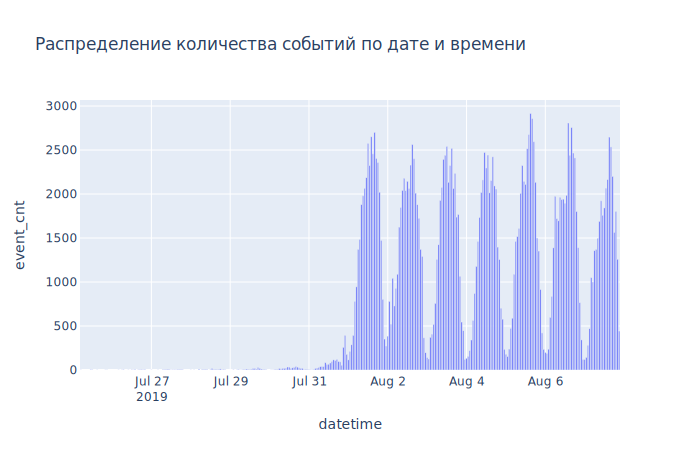

In [16]:
fig = px.bar(date_df, 
             x='datetime', y='event_cnt', 
             title='Распределение количества событий по дате и времени')
fig.show()

На графике четко видны характерные распределения количества событий во времени со всплесками днем и низкой активностью ночью.  Но такая картина характерна не для всего датафрейма. Для ранних дат количество событий слишком низкое, это может «перекашивать данные». Можно сказать, что данные до 22.00 31.07.2019г. не релевантны, их нужно отбросить. 
В итоге мы имеем временной промежуток с 22.00 31.07.2019 до 21.00 07.08.2019. 

In [17]:
#найдем метку самого раннего события в выбранный период времени
logs_data.loc[logs_data['datetime'] == '2019-07-31 22:00:00']['timestamp'].min()

1564608603

In [18]:
#выделим срез релевантных данных 
test_data = logs_data.query('timestamp >= 1564608603')
display(len(test_data))

241491

In [19]:
display(len(logs_data))

243713

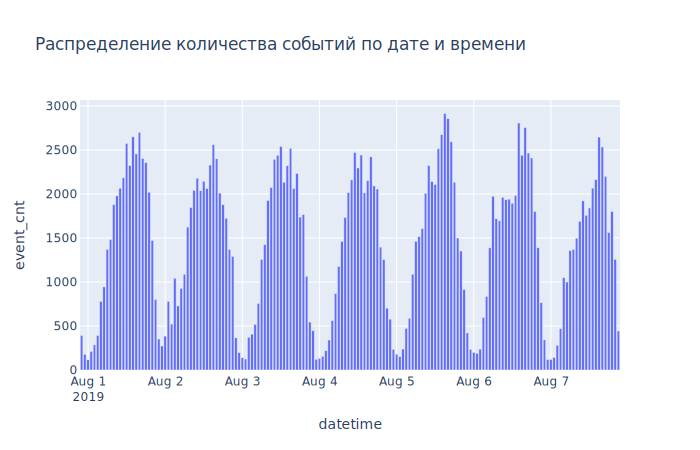

In [20]:
#посмотрим на отфильтрованные данные в графике
test_df = test_data\
    .groupby(['datetime'], as_index=False)\
    .agg({'event' : 'count'})\
    .rename(columns={'event':'event_cnt'})
test_df

fig = px.bar(test_df, 
             x='datetime', y='event_cnt', 
             title='Распределение количества событий по дате и времени',)
fig.show()

Сколько событий и пользователей мы потеряли, отбросив старые данные?

In [21]:
#найдем разницу в количестве событий в датасетах
len(logs_data['event']) - len(test_data['event'])

2222

In [22]:
#найдем разницу в количестве пользователей в датасетах
logs_data['user_id'].nunique() - test_data['user_id'].nunique()

13

Количество удаленных событий - 2222, что менее 1% от объема данных. Пользователей стало меньше на 13 человек из первоначальных 7551. Это незначительные потери. 

Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [23]:
test_data.head()

,event,user_id,timestamp,group_id,datetime,date
2222,MainScreenAppear,8376730413928148138,1564608603,246,2019-07-31 22:00:00,2019-07-31
2223,MainScreenAppear,624637828747274142,1564608605,246,2019-07-31 22:00:00,2019-07-31
2224,OffersScreenAppear,624637828747274142,1564608608,246,2019-07-31 22:00:00,2019-07-31
2225,MainScreenAppear,3807928414254040303,1564608609,247,2019-07-31 22:00:00,2019-07-31
2226,MainScreenAppear,4612453265087815110,1564608619,247,2019-07-31 22:00:00,2019-07-31


In [24]:
test_data['group_id'].value_counts()

248    84784
246    79500
247    77207
Name: group_id, dtype: int64

Все три экспериментальные группы на месте. 

<div id='step4'/>

## Анализ воронки событий

Какие события в логах встречаются чаще всего?

In [25]:
len(test_data['event'])

241491

In [26]:
test_data['event'].value_counts()

MainScreenAppear           117745
OffersScreenAppear          46472
CartScreenAppear            42327
PaymentScreenSuccessful     33939
Tutorial                     1008
Name: event, dtype: int64

В отсортированном логе 241491 событий 5-ти видов: `MainScreenAppear`, `OffersScreenAppear`, `CartScreenAppear`, `PaymentScreenSuccessful`, `Tutorial` (по убыванию популярности).

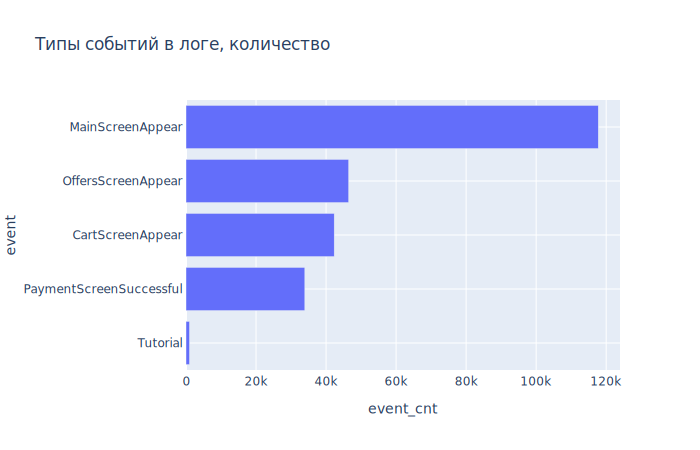

In [27]:
#построим график для наглядности
event_df = test_data\
    .groupby(['event'], as_index=False)\
    .agg({'user_id' : 'count'})\
    .rename(columns={'user_id':'event_cnt'})

fig = px.bar(event_df.sort_values(by='event_cnt'), 
             x='event_cnt', y='event', 
             title='Типы событий в логе, количество', orientation='h')
fig.show()

Сколько пользователей совершали каждое из этих событий?

In [28]:
test_data.sample()

,event,user_id,timestamp,group_id,datetime,date
137410,PaymentScreenSuccessful,5441176224935228506,1564945586,246,2019-08-04 19:00:00,2019-08-04


In [29]:
#сгруппируем по типу события и количеству уникальных пользователей
user_df = test_data\
    .groupby(['event'], as_index=False)\
    .agg({'user_id' : 'nunique'})\
    .rename(columns={'user_id':'user_cnt'})
user_df.sort_values(by='user_cnt', ascending = False)

,event,user_cnt
1,MainScreenAppear,7423
2,OffersScreenAppear,4596
0,CartScreenAppear,3735
3,PaymentScreenSuccessful,3539
4,Tutorial,842


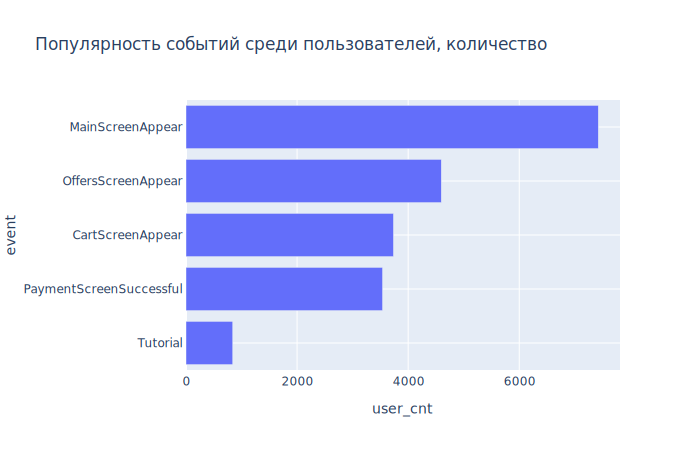

In [30]:
#построим график для наглядности
fig = px.bar(user_df.sort_values(by='user_cnt'), 
             x='user_cnt', y='event', 
             title='Популярность событий среди пользователей, количество', orientation='h')
fig.show()

In [31]:
#рассчитаем соотношений получиенного количества пользователей к общему числу уникальных пользователей
user_df['user_part_from_total'] = user_df['user_cnt'] / test_data['user_id'].nunique()
user_df = user_df.sort_values(by='user_cnt', ascending = False).reset_index(drop = True)
user_df

,event,user_cnt,user_part_from_total
0,MainScreenAppear,7423,0.984744
1,OffersScreenAppear,4596,0.609711
2,CartScreenAppear,3735,0.495490
3,PaymentScreenSuccessful,3539,0.469488
4,Tutorial,842,0.111701


Количество пользователей последовательно убывает, начиная с 7423 до 842 человек (0,98% и 0,11% соответственно). 

Я предполагаю, что порядок событий совпадает с уменьшением количества пользователей. То есть, 1 - `MainScreenAppear`, 2 - `OffersScreenAppear`, 3 - `CartScreenAppear`, 4 - `PaymentScreenSuccessful`. Я считаю, что `Tutorial` не нужно добавлять в воронку событий, т.к. количество совершивших его пользователей слишком мало. Похоже, оно не сильно влияет на факт покупки и само по себе совершается очень редко. 

Посчитаем конверсию пользователей в воронке событий:

In [32]:
#удалим Tutorial, чтобы составить воронку событий
funnel = user_df.drop([4])
funnel

,event,user_cnt,user_part_from_total
0,MainScreenAppear,7423,0.984744
1,OffersScreenAppear,4596,0.609711
2,CartScreenAppear,3735,0.495490
3,PaymentScreenSuccessful,3539,0.469488


In [33]:
#создадим вспомогательный столбец, чтобы расчитать соотношение пользователей по воронке событий, затем удалим его
funnel['tmp'] = funnel['user_cnt'].shift(periods=1)
funnel['event_ratio'] = funnel['user_cnt'] / funnel['tmp']
funnel = funnel.drop(columns=['tmp'])
funnel

,event,user_cnt,user_part_from_total,event_ratio
0,MainScreenAppear,7423,0.984744,NaN
1,OffersScreenAppear,4596,0.609711,0.619157
2,CartScreenAppear,3735,0.495490,0.812663
3,PaymentScreenSuccessful,3539,0.469488,0.947523


In [34]:
#заменим NaN на 100%
funnel.fillna(1)

,event,user_cnt,user_part_from_total,event_ratio
0,MainScreenAppear,7423,0.984744,1.000000
1,OffersScreenAppear,4596,0.609711,0.619157
2,CartScreenAppear,3735,0.495490,0.812663
3,PaymentScreenSuccessful,3539,0.469488,0.947523


Больше всего пользователей теряется на втором шаге - почти 40% не доходят до события `OffersScreenAppear`. К третьему шагу приходят больше 80%, а к заключительному - 95%. 

In [35]:
funnel.loc[3, 'user_cnt'] / funnel.loc[0, 'user_cnt']

0.47676141721675874

Весь цикл с начала до конца проходят 47,6% пользователей. 

<div id='step5'/>

## Анализ результатов А/А/В-эксперимента

Изучим состав тестируемых групп:

In [36]:
test_data.sample()

,event,user_id,timestamp,group_id,datetime,date
184540,MainScreenAppear,5387094564511646555,1565078323,248,2019-08-06 08:00:00,2019-08-06


In [37]:
group_df = test_data\
    .groupby(['group_id'], as_index=False)\
    .agg({'user_id' : 'nunique'})\
    .rename(columns={'user_id':'user_cnt'})
group_df

,group_id,user_cnt
0,246,2484
1,247,2517
2,248,2537


Группы различаются по составу: в 246 - 2484, в 247 - 2517, в 248 - 2537 пользователей. 

Находят ли статистические критерии разницу между выборками 246 и 247 - это контрольные группы для А/А-эксперимента? Проверим на самом популярном событии, что разбиение на группы работает корректно.

In [38]:
#сгруппируем данные по событиям, группам и количеству уникальных пользователей
grouped_data = test_data.pivot_table(index='event', 
                                     columns='group_id', 
                                     values='user_id', 
                                     aggfunc='nunique').reset_index() 
grouped_data.columns=['event', '246', '247', '248'] 
grouped_data = grouped_data.sort_values(by='246', ascending = False).reset_index(drop = True)
grouped_data

,event,246,247,248
0,MainScreenAppear,2450,2479,2494
1,OffersScreenAppear,1542,1523,1531
2,CartScreenAppear,1266,1239,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,284,280


In [39]:
#рассчитаем соотношение пользоватлей в группах к общему числу пользователей
grouped_data['246_ratio'] = grouped_data['246'] / group_df.loc[0, 'user_cnt']
grouped_data['247_ratio'] = grouped_data['247'] / group_df.loc[1, 'user_cnt']
grouped_data['248_ratio'] = grouped_data['248'] / group_df.loc[2, 'user_cnt']
grouped_data

,event,246,247,248,246_ratio,247_ratio,248_ratio
0,MainScreenAppear,2450,2479,2494,0.986312,0.984903,0.983051
1,OffersScreenAppear,1542,1523,1531,0.620773,0.605085,0.603469
2,CartScreenAppear,1266,1239,1230,0.509662,0.492253,0.484825
3,PaymentScreenSuccessful,1200,1158,1181,0.483092,0.460072,0.465510
4,Tutorial,278,284,280,0.111916,0.112833,0.110367


Теперь проверим статистическую разницу между группами 246 и 247 на основе самого популярного события c помощью гипотезы о равенстве долей. 

In [40]:
alpha = .05 

#укажем исходное количество пользователей и пользователей для первого события
event_0 = grouped_data.loc[0, ['246', '247']]
total_users = group_df.loc[:1, 'user_cnt']

# доля пользователей, совершивших первое событие в группе 246:
p1 = grouped_data.loc[0, '246_ratio']

# доля пользователей, совершивших первое событие в группе 247:
p2 = grouped_data.loc[0, '247_ratio']

p_combined = (event_0[0] + event_0[1]) / (total_users[0] + total_users[1])
difference = p1 - p2

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total_users[0] + 1/total_users[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для первого события статистической разницы между 246 и 247 группами нет. Посмотрим, что происходит с остальными событиями. Для этого создадим функцию. 

In [41]:
#я попробовала изменить функцию так, чтобы сделать ее более универсальной 
      
def event_stats(data, column1, column2, df, row1, row2):
    for i in range(len(data)):
        successes1 = data.loc[i, column1]
        successes2 = data.loc[i, column2]
        trials1 = df.loc[row1, 'user_cnt']
        trials2 = df.loc[row2, 'user_cnt']
        
        alpha = .05
        p1 = successes1/trials1
        p2 = successes2/trials2
        p_combined = (successes1 + successes2) / (trials1 + trials2)
        difference = p1 - p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('p-значение: ', p_value)
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")


event_stats(grouped_data, '246', '247', group_df, 0, 1)                                     

p-значение:  0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2548030321293888
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9182790262812368
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Между долями 246 и 247 групп статистической разницы нет. Можно сказать, что разбиение на группы работает корректно. 

Аналогично сравним результаты в экспериментальной группе с каждой из контрольных групп в отдельности по каждому событию. 

Сравним результаты между группой 248 и контрольной группой 246 по каждому событию.

In [42]:
#используем универсальную функцию
event_stats(grouped_data, '246', '248', group_df, 0, 2)  

p-значение:  0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.861330427953267
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Между долями 246 и 247 групп статистической разницы нет. 

Сравним результаты между группой 248 и контрольной группой 247.

In [43]:
#используем универсальную функцию
event_stats(grouped_data, '247', '248', group_df, 1, 2)  

p-значение:  0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9064474651756644
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5973544899382834
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6982134522789267
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.780700777950111
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Между долями 248 и 247 групп статистической разницы нет.

Сравним результаты между объединенными контрольными группами 246 и 247, и экспериментальной 248 группой. 

In [44]:
grouped_data.sample()

,event,246,247,248,246_ratio,247_ratio,248_ratio
2,CartScreenAppear,1266,1239,1230,0.509662,0.492253,0.484825


In [45]:
#добавим столбец с объединенными группами в датасет
grouped_data['246_247'] = grouped_data['246'] + grouped_data['247']
grouped_data

,event,246,247,248,246_ratio,247_ratio,248_ratio,246_247
0,MainScreenAppear,2450,2479,2494,0.986312,0.984903,0.983051,4929
1,OffersScreenAppear,1542,1523,1531,0.620773,0.605085,0.603469,3065
2,CartScreenAppear,1266,1239,1230,0.509662,0.492253,0.484825,2505
3,PaymentScreenSuccessful,1200,1158,1181,0.483092,0.460072,0.465510,2358
4,Tutorial,278,284,280,0.111916,0.112833,0.110367,562


In [46]:
group_df

,group_id,user_cnt
0,246,2484
1,247,2517
2,248,2537


In [47]:
# добавим численность объединенной группы A1A2
A1A2 = pd.DataFrame({'group_id':'246_247', 'user_cnt':[2484 + 2517]})
group_df = group_df.append(A1A2).reset_index(drop=True)
group_df

,group_id,user_cnt
0,246,2484
1,247,2517
2,248,2537
3,246_247,5001


In [48]:
#трансформируем функцию, чтобы включить данные об с объединенной контрольной группой

def event_stats_combined(data, column1, column2, df, row1):
    for i in range(len(data)):
        successes1 = data.loc[i, column1]
        successes2 = data.loc[i, column2]
        trials1 = df.loc[row1, 'user_cnt']
        #вот тут надо просто заменить значение переменной, я решила не автоматизировать, т.к. ресурсов на автоматизацию здесь
        #тратится гораздо больше, чем на ручную корректировку
        trials2 = group_df.loc[0, 'user_cnt'] + group_df.loc[1, 'user_cnt']
        
        alpha = .05
        p1 = successes1/trials1
        p2 = successes2/trials2
        p_combined = (successes1 + successes2) / (trials1 + trials2)
        difference = p1 - p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('p-значение: ', p_value)
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")


event_stats_combined(grouped_data, '248', '246_247', group_df, 2) 

p-значение:  0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.42877251768430646
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18714829717090664
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6221237660987535
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7933898496270473
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [49]:
#или используем скорректированную старую функцию
event_stats(grouped_data, '246_247', '248', group_df, 3, 2)  

p-значение:  0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.42877251768430646
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18714829717090664
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6221237660987535
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7933898496270473
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам сравнения долей между экспериментальной и объединенными контрольными группами статистической разницы также не обнаружилось.

Что мы имеем: между 246 и 247 группами нет статистической разницы долей. Между группами 246 и 248 нет статистической разницы долей, между группами 247 и 248 нет статистической разницы долей. Между экспериментальной и объединенными контрольными группами также нет статистической разницы долей. Поэтому я считаю, что на данном этапе эксперимента статистической разницы между группами нет. 

Вывод: изменения, которые тестировали в экспериментальной группе, не повлияли на поведение пользователей так, чтобы создать статистически значимую разницу.

<div id='step6'/>

## Общий вывод

##### Задача:
##### - изучить воронку продаж для пользователей мобильного приложения.
##### - исследовать результаты A/A/B-эксперимента по смене шрифтов в приложении. 

В начале работы я подготовила данные для анализа: удостоверилась, что нет пропусков, удалила дубликаты (меньше 1% данных), переименовала названия столбцов. Я добавила столбец с датой и временем, отдельный столбец дат.

### Изучение и проверка данных

Всего в логе 243713 событий 5-ти видов:  `MainScreenAppear`, `OffersScreenAppear`, `CartScreenAppear`,  `PaymentScreenSuccessful`, `Tutorial` и 7551 пользователь.

На каждого пользователя приходится в среднем 32,3 события.

Минимальная дата событий - 25.07.2019, максимальная - 07.08.2019.

На графике четко видны характерные распределения количества событий во времени со всплесками днем и низкой активностью ночью. Но такая картина характерна не для всего датафрейма. Для ранних дат количество событий слишком низкое, это может «перекашивать данные». Можно сказать, что данные до 22.00 31.07.2019г. не релевантны, их нужно отбросить. В итоге мы имеем временной промежуток с 22.00 31.07.2019 до 21.00 07.08.2019.

Количество удаленных событий - 2222, что менее 1% от объема данных. Пользователей стало меньше на 13 человек из первоначальных 7551. Это незначительные потери. Все три экспериментальные группы на месте.

### Анализ воронки событий

В отсортированном логе 241491 событий 5-ти видов: `MainScreenAppear`, `OffersScreenAppear`, `CartScreenAppear`, `PaymentScreenSuccessful`, `Tutorial` (по убыванию популярности).

Количество пользователей последовательно убывает, начиная с 7423 до 842 человек (0,98% и 0,11% соответственно).

Я предполагаю, что порядок событий совпадает с уменьшением количества пользователей. То есть, 1 - `MainScreenAppear`, 2 - `OffersScreenAppear`, 3 - `CartScreenAppear`, 4 - `PaymentScreenSuccessful`. Я считаю, что `Tutorial` не нужно добавлять в воронку событий, т.к. количество совершивших его пользователей слишком мало. Похоже, оно не сильно влияет на факт покупки и само по себе совершается очень редко.

Больше всего пользователей теряется на втором шаге - почти 40% не доходят до события OffersScreenAppear. К третьему шагу приходят больше 80%, а к заключительному - 95%.
 
Весь цикл с начала до конца проходят 47,6% пользователей.

### Анализ результатов А/А/В-эксперимента
 
Группы различаются по составу: в 246 - 2484, в 247 - 2517, в 248 - 2537 пользователей.
 
Я проверяла статистическую разницу между группами 246 и 247 на основе самого популярного события c помощью гипотезы о равенстве долей.

Для первого события статистической разницы между группами нет. Анализ последующих событий показал, что между долями 246 и 247 групп нет статистической разницы. Разбиение на группы работает корректно.
 
Сравнение результатов по каждому событию между группой 248 и контрольной группой 246 также показало отсутствие статистической разницы между долями.

Статистической разницы между долями групп 247 и 248 нет.
По результатам сравнения долей между экспериментальной и объединенными контрольными группами статистической разницы также не обнаружилось.

Что мы имеем: между 246 и 247 группами нет статистической разницы долей. Между группами 246 и 248 нет статистической разницы долей, между группами 247 и 248 нет статистической разницы долей. Между экспериментальной и объединенными контрольными группами также нет статистической разницы долей. Поэтому я считаю, что на данном этапе эксперимента статистической разницы между группами нет. 

Вывод: изменения, которые тестировали в экспериментальной группе, не повлияли на поведение пользователей так, чтобы создать статистически значимую разницу.
Я использовала уровень значимости alpha = .05 и сделала 21 проверку гипотез.

**Вывод:**
**Четыре из пяти событий, записанных в логе, складываются в логичную воронку событий. Это `MainScreenAppear`, `OffersScreenAppear`, `CartScreenAppear`, `PaymentScreenSuccessful`. `Tutorial` можно считать опциональным событием, которое не влияет на поведение пользователей. Событие `MainScreenAppear` происходит с 98% пользователей, но на переходе ко второму шагу `OffersScreenAppear` теряется почти 40% из них. На остальных шагах потери менее значительны – 20% на переходе к событию `CartScreenAppear`,  и 5% отваливается при оплате в `PaymentScreenSuccessful`. В итоге до конца воронки доходит только 47,6% пользователей.** 
**Анализ результатов А/А/В эксперимента не выявил статистически значимой разницы долей между контрольными группами и экспериментальной. Эксперимент показал, что изменение шрифта не влияет на поведение пользователей.**
